In [15]:
import pandas as pd
import json
import string
import pickle
import os
import random
import time
import numpy as np
from PIL import Image
from collections import Counter, OrderedDict

import torch
from torch.utils.data import Dataset
from torchtext.vocab import vocab
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score

In [12]:
def split_fbhm(directory):
    train = []
    with open(f"{directory}train.jsonl") as f:
        for line in f:
            sample = json.loads(line)
            train.append([sample["img"], sample["text"], sample["label"]])

    dev = []
    with open(f"{directory}dev_seen.jsonl") as f:
        for line in f:
            sample = json.loads(line)
            dev.append([sample["img"], sample["text"], sample["label"]])

    return pd.DataFrame(train, columns=["img", "text", "label"]), pd.DataFrame(
        dev, columns=["img", "text", "label"]
    )

In [13]:
def text_clean(text):
    clean = []
    for i, text_ in enumerate(text):
        if type(text_) is str:
            text_ = text_.lower()  # lower case
            text_ = text_.translate(
                str.maketrans("", "", string.punctuation)
            )  # remove punctuation
            text_ = "".join([i for i in text_ if not i.isdigit()])  # remove numbers
            text_ = " ".join(text_.split())  # remove double space
            clean.append(text_)
        else:
            clean.append("notext")
    return clean

In [14]:
class FBHM(Dataset):
    def __init__(
        self,
        directory,
        train,
        vocab_size,
        seq_len,
        transform=None,
    ):
        self.directory = directory
        self.train, self.dev = split_fbhm(self.directory)

        # Create the training text corpus vocabulary
        sentences = text_clean(self.train["text"].tolist())
        words = [w for s in sentences for w in s.split()]
        counts = sorted(Counter(words).items(), key=lambda x: x[1], reverse=True)[
            :vocab_size
        ]
        self.vocabulary = vocab(OrderedDict(counts))
        self.vocabulary.insert_token("<pad>", 0)
        self.vocabulary.insert_token("<unk>", 1)
        self.vocabulary.set_default_index(self.vocabulary["<unk>"])

        with open("Data/captions_fbhm.pickle", "rb") as handle:
            self.captions = pickle.load(handle)
        caps_sentences = text_clean([self.captions[x] for x in self.captions])
        self.caps_seq_len = max([len(s.split()) for s in caps_sentences])
        caps_words = [w for s in caps_sentences for w in s.split()]
        caps_counts = sorted(
            Counter(caps_words).items(), key=lambda x: x[1], reverse=True
        )
        self.caps_vocabulary = vocab(OrderedDict(caps_counts))
        self.caps_vocabulary.insert_token("<pad>", 0)
        self.caps_vocabulary.insert_token("<unk>", 1)
        self.caps_vocabulary.insert_token("<sos>", 2)
        self.caps_vocabulary.insert_token("<eos>", 3)
        self.caps_vocabulary.set_default_index(self.caps_vocabulary["<unk>"])

        # External knowledge
        self.attributes = pd.read_csv("Data/protected_attributes_fbhm.csv")[
            ["face_name_align", "race", "gender", "age"]
        ]
        self.max_attr = 7 * 3
        self.attribute_map = {
            "<pad>": 0,
            "White": 1,
            "Indian": 2,
            "Southeast Asian": 3,
            "Middle Eastern": 4,
            "Latino_Hispanic": 5,
            "Black": 6,
            "East Asian": 7,
            "Male": 8,
            "Female": 9,
            "0-2": 10,
            "3-9": 11,
            "10-19": 12,
            "20-29": 13,
            "30-39": 14,
            "40-49": 15,
            "50-59": 16,
            "60-69": 17,
            "70+": 18,
        }

        # Pick the split's examples to make the dataset
        self.memes = self.train if train else self.dev

        self.seq_len = seq_len
        self.transform = transform

    def __len__(self):
        return len(self.memes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.memes["img"][idx]
        image = Image.open(os.path.join(self.directory, image_name)).convert("RGB")
        text = text_clean([self.memes["text"][idx]])[0]
        text_index = self.vocabulary(text.split())
        label = self.memes["label"][idx]
        caption = text_clean([self.captions[image_name.replace("img/", "")]])[0]
        caption_index = self.caps_vocabulary(caption.split())
        image_attributes = self.attributes[
            self.attributes["face_name_align"].str.contains(image_name[4:-4])
        ].values[:, 1:]
        external_index = [self.attribute_map[y] for x in image_attributes for y in x]
        sample = {
            "image": image,
            "text": text,
            "text_index": text_index[: self.seq_len]
            if len(text_index) >= self.seq_len
            else text_index
            + [self.vocabulary["<pad>"]] * (self.seq_len - len(text_index)),
            "label": label,
            "caption": caption,
            "caption_index": [self.caps_vocabulary["<sos>"]]
            + caption_index
            + [self.caps_vocabulary["<eos>"]]
            + [self.caps_vocabulary["<pad>"]]
            * (self.caps_seq_len - len(caption_index)),
            "external_index": external_index[: self.max_attr]
            if len(external_index) >= self.max_attr
            else external_index
            + [self.attribute_map["<pad>"]] * (self.max_attr - len(external_index)),
        }
        sample["text_index"] = torch.tensor(sample["text_index"])
        sample["caption_index"] = torch.tensor(sample["caption_index"])
        sample["external_index"] = torch.tensor(sample["external_index"])
        if self.transform:
            sample["image"] = self.transform(sample["image"])
        return sample

In [15]:
class ImageOnly(torch.nn.Module):
    def __init__(self, pretrained, hidden_dim, num_classes, device):
        super().__init__()
        self.device = device
        self.num_classes = num_classes

        img_fe = resnet18(pretrained=pretrained)
        img_fe.fc = torch.nn.Identity()
        self.img_fe = img_fe
        self.fc_img1 = torch.nn.Linear(512, hidden_dim * 2)
        self.fc = torch.nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        y = torch.tanh(self.fc_img1(self.img_fe(x["image"].to(self.device))))
        if isinstance(self.num_classes, dict):
            return [
                self.fc_hum(y),
                self.fc_sar(y),
                self.fc_off(y),
                self.fc_mot(y),
            ]
        elif isinstance(self.num_classes, int):
            return self.fc(y)

In [16]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    raise Exception("No GPUs available!")

In [16]:
datdir = "Data/"
savpath = "results/baselines_fbhm.pickle"
imnet_mean = [0.485, 0.456, 0.406]
imnet_std = [0.229, 0.224, 0.225]
INIT_IMG_SIZE = 256
IMG_SIZE = 224
VOCAB_SIZE = 2222  # 2222 words have at least 5 occurrences
SEQ_LEN = 20  # 90% quantile is 20, 95% is 24 and 99% is 34
hidden_dims = [64, 128]
batch_size = 128
epochs = 10
learning_rates = [1e-3, 1e-4]
pretrained = [True, False]

In [28]:
results = []
train_ds = FBHM(
    directory=datdir,
    train=True,
    vocab_size=VOCAB_SIZE,
    seq_len=SEQ_LEN,
    transform=transforms.Compose(
        [
            transforms.Resize((INIT_IMG_SIZE, INIT_IMG_SIZE)),
            transforms.RandomCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(imnet_mean, imnet_std),
        ]
    ),
)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)
val_ds = FBHM(
    directory=datdir,
    train=False,
    vocab_size=VOCAB_SIZE,
    seq_len=SEQ_LEN,
    transform=transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(imnet_mean, imnet_std),
        ]
    ),
)
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False,
)

In [29]:
ckpt = f"ckpt/baseline_fbhm_image.pt"
max_auc = 0
for learning_rate in learning_rates:
    for pretrained_ in pretrained:
        for hidden_dim in hidden_dims:
            print(f"lr={learning_rate} - pt={pretrained_} - hd={hidden_dim}")

            model = ImageOnly(
                pretrained=pretrained_,
                hidden_dim=hidden_dim,
                num_classes=1,
                device=device,
            ).to(device)
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            start = time.time()
            val_loss = []
            val_acc = []
            val_auc = []
            for epoch in range(epochs):
                model.train()
                for data in train_dl:
                    labels = data["label"].to(device)
                    optimizer.zero_grad()
                    outputs = model(data)
                    loss_ = criterion(outputs, labels.float().view(-1, 1))
                    loss_.backward()
                    optimizer.step()

                model.eval()
                val_loss_ = 0
                y_score = []
                y_true = []
                y_pred = []
                with torch.no_grad():
                    for data in val_dl:
                        labels = data["label"].to(device)
                        outputs = model(data)
                        val_loss_ += criterion(
                            outputs, labels.float().view(-1, 1)
                        ).item()
                        score = torch.sigmoid(outputs.data)
                        y_score.extend(score.cpu().numpy().tolist())
                        y_true.extend(labels.cpu().numpy().tolist())
                        y_pred.extend((score > 0.5).cpu().numpy().tolist())

                val_loss_ /= len(val_dl)
                val_acc_ = accuracy_score(y_true, y_pred)
                val_auc_ = roc_auc_score(y_true, y_score)

                if val_auc_ > max_auc:
                    max_auc = val_auc_
                    torch.save(model, ckpt)
                    with open(f"{ckpt[:-3]}.txt", "w") as file:
                        file.write(
                            json.dumps(
                                {
                                    "lr": learning_rate,
                                    "pretrained": pretrained_,
                                    "hidden_dim": hidden_dim,
                                    "val_loss": val_loss_,
                                    "val_acc": val_acc_,
                                    "val_auc": val_auc_,
                                    "epoch": epoch,
                                }
                            )
                        )

                val_loss.append(val_loss_)
                val_acc.append(val_acc_)
                val_auc.append(val_auc_)

                print(
                    f"Epoch {epoch+1}/{epochs} - loss: {val_loss_:.4f} - acc: {val_acc_:.4f} - auc: {val_auc_:.4f}"
                )

                if epoch == int(epochs / 2) - 1:
                    for g in optimizer.param_groups:
                        g["lr"] = learning_rate / 10

            result = {
                "lr": learning_rate,
                "pretrained": pretrained_,
                "hidden_dim": hidden_dim,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_auc": val_auc,
                "time": time.time() - start,
            }
            print(json.dumps(result, indent=4))
            results.append(result)

            with open(savpath, "wb") as h:
                pickle.dump(results, h, protocol=pickle.HIGHEST_PROTOCOL)

lr=0.001 - pt=True - hd=64


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7163 - acc: 0.5020 - auc: 0.4791
Epoch 2/10 - loss: 0.7687 - acc: 0.5060 - auc: 0.4942
Epoch 3/10 - loss: 0.7299 - acc: 0.5060 - auc: 0.4749
Epoch 4/10 - loss: 0.7905 - acc: 0.5040 - auc: 0.4939
Epoch 5/10 - loss: 0.7861 - acc: 0.5000 - auc: 0.4999
Epoch 6/10 - loss: 0.7360 - acc: 0.5120 - auc: 0.5133
Epoch 7/10 - loss: 0.7315 - acc: 0.5040 - auc: 0.5174
Epoch 8/10 - loss: 0.7421 - acc: 0.5240 - auc: 0.5222
Epoch 9/10 - loss: 0.7498 - acc: 0.5260 - auc: 0.5267
Epoch 10/10 - loss: 0.7871 - acc: 0.5140 - auc: 0.5333
{
    "lr": 0.001,
    "pretrained": true,
    "hidden_dim": 64,
    "val_loss": [
        0.7162652313709259,
        0.7687285542488098,
        0.7299027293920517,
        0.7904769778251648,
        0.7861035764217377,
        0.7359667122364044,
        0.7315195202827454,
        0.7421464920043945,
        0.7497585564851761,
        0.7870551943778992
    ],
    "val_acc": [
        0.502,
        0.506,
        0.506,
        0.504,
        0.5,


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7557 - acc: 0.5100 - auc: 0.4547
Epoch 2/10 - loss: 0.7436 - acc: 0.5040 - auc: 0.5150
Epoch 3/10 - loss: 0.7503 - acc: 0.5060 - auc: 0.5096
Epoch 4/10 - loss: 0.7689 - acc: 0.4980 - auc: 0.4890
Epoch 5/10 - loss: 0.7774 - acc: 0.5040 - auc: 0.5648
Epoch 6/10 - loss: 0.7780 - acc: 0.5000 - auc: 0.5371
Epoch 7/10 - loss: 0.7668 - acc: 0.5140 - auc: 0.5221
Epoch 8/10 - loss: 0.7864 - acc: 0.4980 - auc: 0.5446
Epoch 9/10 - loss: 0.8380 - acc: 0.5060 - auc: 0.5519
Epoch 10/10 - loss: 0.7554 - acc: 0.4940 - auc: 0.5054
{
    "lr": 0.001,
    "pretrained": true,
    "hidden_dim": 128,
    "val_loss": [
        0.7557247877120972,
        0.7435712963342667,
        0.7502655684947968,
        0.76885125041008,
        0.7773639857769012,
        0.7779788970947266,
        0.7668276727199554,
        0.7864149957895279,
        0.8379767835140228,
        0.7553855627775192
    ],
    "val_acc": [
        0.51,
        0.504,
        0.506,
        0.498,
        0.504,


/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7056 - acc: 0.5100 - auc: 0.5027
Epoch 2/10 - loss: 0.7344 - acc: 0.5140 - auc: 0.4786
Epoch 3/10 - loss: 0.7793 - acc: 0.5060 - auc: 0.5003
Epoch 4/10 - loss: 0.7258 - acc: 0.5120 - auc: 0.4865
Epoch 5/10 - loss: 0.7213 - acc: 0.5120 - auc: 0.4992
Epoch 6/10 - loss: 0.7401 - acc: 0.5080 - auc: 0.5166
Epoch 7/10 - loss: 0.7375 - acc: 0.5200 - auc: 0.5075
Epoch 8/10 - loss: 0.7346 - acc: 0.5120 - auc: 0.5135
Epoch 9/10 - loss: 0.7398 - acc: 0.5120 - auc: 0.5173
Epoch 10/10 - loss: 0.7241 - acc: 0.5080 - auc: 0.5022
{
    "lr": 0.001,
    "pretrained": false,
    "hidden_dim": 64,
    "val_loss": [
        0.7056373655796051,
        0.7344285249710083,
        0.7792947590351105,
        0.7257837206125259,
        0.7212975323200226,
        0.7400925904512405,
        0.7374500036239624,
        0.7345839589834213,
        0.7398312091827393,
        0.7240575551986694
    ],
    "val_acc": [
        0.51,
        0.514,
        0.506,
        0.512,
        0.512

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7613 - acc: 0.5060 - auc: 0.5077
Epoch 2/10 - loss: 0.7460 - acc: 0.5060 - auc: 0.5288
Epoch 3/10 - loss: 0.7878 - acc: 0.5060 - auc: 0.5187
Epoch 4/10 - loss: 0.7294 - acc: 0.5060 - auc: 0.4964
Epoch 5/10 - loss: 0.7714 - acc: 0.5060 - auc: 0.5314
Epoch 6/10 - loss: 0.7304 - acc: 0.5060 - auc: 0.5058
Epoch 7/10 - loss: 0.7303 - acc: 0.5060 - auc: 0.5063
Epoch 8/10 - loss: 0.7362 - acc: 0.5060 - auc: 0.4878
Epoch 9/10 - loss: 0.7283 - acc: 0.5040 - auc: 0.4878
Epoch 10/10 - loss: 0.7379 - acc: 0.5060 - auc: 0.4960
{
    "lr": 0.001,
    "pretrained": false,
    "hidden_dim": 128,
    "val_loss": [
        0.7613092809915543,
        0.745988667011261,
        0.7878270298242569,
        0.7293851226568222,
        0.7714262306690216,
        0.7303804755210876,
        0.7302699536085129,
        0.7361501008272171,
        0.7283380627632141,
        0.7379189729690552
    ],
    "val_acc": [
        0.506,
        0.506,
        0.506,
        0.506,
        0.50

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7486 - acc: 0.4880 - auc: 0.5057
Epoch 2/10 - loss: 0.8016 - acc: 0.5080 - auc: 0.5260
Epoch 3/10 - loss: 0.7976 - acc: 0.5000 - auc: 0.5142
Epoch 4/10 - loss: 0.9794 - acc: 0.5200 - auc: 0.5156
Epoch 5/10 - loss: 1.0661 - acc: 0.5100 - auc: 0.5018
Epoch 6/10 - loss: 1.0046 - acc: 0.5020 - auc: 0.4953
Epoch 7/10 - loss: 1.0452 - acc: 0.5080 - auc: 0.4911
Epoch 8/10 - loss: 1.0872 - acc: 0.5100 - auc: 0.4874
Epoch 9/10 - loss: 1.1610 - acc: 0.5120 - auc: 0.4894
Epoch 10/10 - loss: 1.1914 - acc: 0.5080 - auc: 0.4857
{
    "lr": 0.0001,
    "pretrained": true,
    "hidden_dim": 64,
    "val_loss": [
        0.7485533058643341,
        0.8016250431537628,
        0.7975650578737259,
        0.9793739020824432,
        1.0660870224237442,
        1.0046214759349823,
        1.045150265097618,
        1.0871795415878296,
        1.1610159277915955,
        1.1913834661245346
    ],
    "val_acc": [
        0.488,
        0.508,
        0.5,
        0.52,
        0.51,
  

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7874 - acc: 0.5080 - auc: 0.5157
Epoch 2/10 - loss: 0.8511 - acc: 0.5120 - auc: 0.5236
Epoch 3/10 - loss: 0.8634 - acc: 0.5140 - auc: 0.5605
Epoch 4/10 - loss: 0.8900 - acc: 0.5260 - auc: 0.5405
Epoch 5/10 - loss: 0.9880 - acc: 0.4860 - auc: 0.4934
Epoch 6/10 - loss: 1.0489 - acc: 0.5080 - auc: 0.4931
Epoch 7/10 - loss: 1.0733 - acc: 0.5020 - auc: 0.5002
Epoch 8/10 - loss: 1.1742 - acc: 0.5120 - auc: 0.4979
Epoch 9/10 - loss: 1.1762 - acc: 0.5000 - auc: 0.4969
Epoch 10/10 - loss: 1.2616 - acc: 0.5100 - auc: 0.4988
{
    "lr": 0.0001,
    "pretrained": true,
    "hidden_dim": 128,
    "val_loss": [
        0.7873888909816742,
        0.8511261641979218,
        0.8633584082126617,
        0.8900334984064102,
        0.9880286902189255,
        1.0488757193088531,
        1.0732847899198532,
        1.1741682142019272,
        1.176217257976532,
        1.2616241872310638
    ],
    "val_acc": [
        0.508,
        0.512,
        0.514,
        0.526,
        0.48

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7508 - acc: 0.5020 - auc: 0.4814
Epoch 2/10 - loss: 0.7127 - acc: 0.5120 - auc: 0.5270
Epoch 3/10 - loss: 0.7218 - acc: 0.4960 - auc: 0.4664
Epoch 4/10 - loss: 0.7412 - acc: 0.5020 - auc: 0.5106
Epoch 5/10 - loss: 0.7296 - acc: 0.5080 - auc: 0.5189
Epoch 6/10 - loss: 0.7355 - acc: 0.5220 - auc: 0.5235
Epoch 7/10 - loss: 0.7322 - acc: 0.5160 - auc: 0.5266
Epoch 8/10 - loss: 0.7578 - acc: 0.5100 - auc: 0.5314
Epoch 9/10 - loss: 0.7448 - acc: 0.5100 - auc: 0.5301
Epoch 10/10 - loss: 0.7478 - acc: 0.5180 - auc: 0.5297
{
    "lr": 0.0001,
    "pretrained": false,
    "hidden_dim": 64,
    "val_loss": [
        0.7508142292499542,
        0.7126548737287521,
        0.7218264639377594,
        0.7411903440952301,
        0.7295724749565125,
        0.7355390787124634,
        0.7322230339050293,
        0.7577621191740036,
        0.7448443025350571,
        0.7477556765079498
    ],
    "val_acc": [
        0.502,
        0.512,
        0.496,
        0.502,
        0.5

/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/Precog_IS/PIS/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 - loss: 0.7499 - acc: 0.5060 - auc: 0.5075
Epoch 2/10 - loss: 0.7303 - acc: 0.5020 - auc: 0.4719
Epoch 3/10 - loss: 0.7670 - acc: 0.5060 - auc: 0.5261
Epoch 4/10 - loss: 0.7291 - acc: 0.5060 - auc: 0.5131
Epoch 5/10 - loss: 0.7638 - acc: 0.5140 - auc: 0.5123
Epoch 6/10 - loss: 0.7309 - acc: 0.5120 - auc: 0.5245
Epoch 7/10 - loss: 0.7253 - acc: 0.5200 - auc: 0.5271
Epoch 8/10 - loss: 0.7251 - acc: 0.5160 - auc: 0.5206
Epoch 9/10 - loss: 0.7398 - acc: 0.5120 - auc: 0.5263
Epoch 10/10 - loss: 0.7344 - acc: 0.5060 - auc: 0.5368
{
    "lr": 0.0001,
    "pretrained": false,
    "hidden_dim": 128,
    "val_loss": [
        0.7498583197593689,
        0.730268195271492,
        0.7670338749885559,
        0.7291150540113449,
        0.7638344913721085,
        0.730852410197258,
        0.7253458350896835,
        0.7251305282115936,
        0.7398011088371277,
        0.7343770116567612
    ],
    "val_acc": [
        0.506,
        0.502,
        0.506,
        0.506,
        0.51

In [17]:
with open(savpath, "rb") as h:
    results = pickle.load(h)
    # write it in a file
    with open(savpath.replace(".pickle", ".tx"), "w") as file:
        data = json.dumps(results, indent=4)
        data = json.loads(data)
        file.write(json.dumps(results, indent=4))

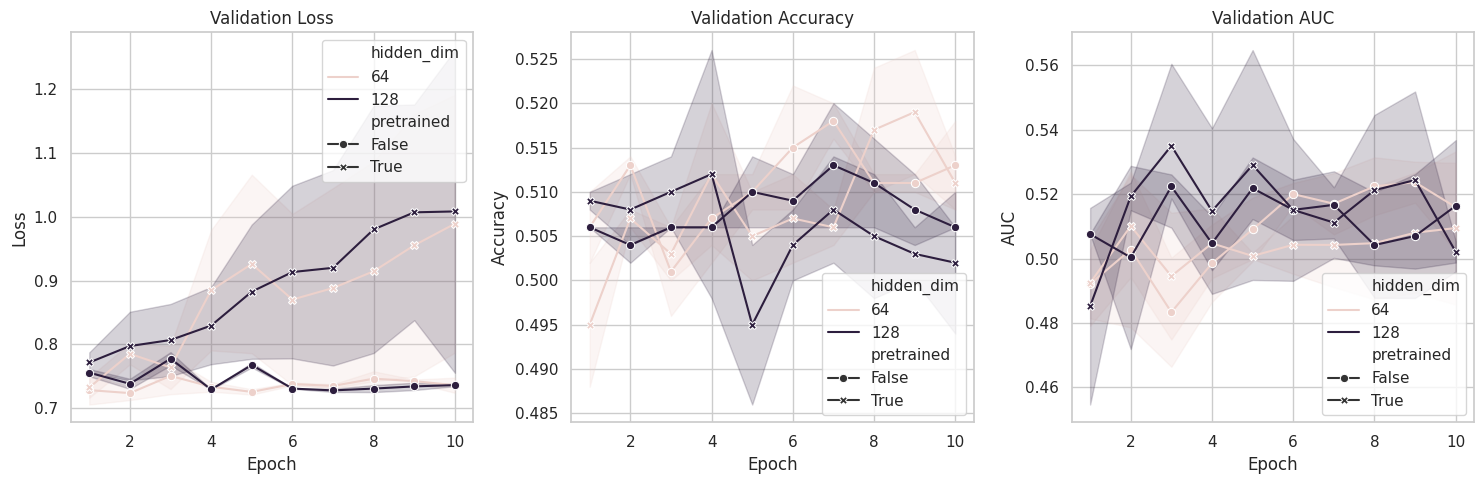

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the data to a DataFrame for easier manipulation
df_list = []
for entry in data:
    for metric in ['val_loss', 'val_acc', 'val_auc']:
        for i, value in enumerate(entry[metric]):
            df_list.append({
                'lr': entry['lr'],
                'pretrained': entry['pretrained'],
                'hidden_dim': entry['hidden_dim'],
                'metric': metric,
                'epoch': i+1,
                'value': value
            })

df = pd.DataFrame(df_list)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
sns.lineplot(data=df[df['metric'] == 'val_loss'], x='epoch', y='value', hue='hidden_dim', style='pretrained', markers=True, dashes=False)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Accuracy plot
plt.subplot(1, 3, 2)
sns.lineplot(data=df[df['metric'] == 'val_acc'], x='epoch', y='value', hue='hidden_dim', style='pretrained', markers=True, dashes=False)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# AUC plot
plt.subplot(1, 3, 3)
sns.lineplot(data=df[df['metric'] == 'val_auc'], x='epoch', y='value', hue='hidden_dim', style='pretrained', markers=True, dashes=False)
plt.title('Validation AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')

plt.tight_layout()
# Save the plot
plt.savefig('results/baselines_fbhm_image.png')
plt.show()


